# Synthetic Galaxy Catalogue: Multiple Voids + LSS Background
This notebook synthesizes a toy 3D galaxy catalogue with:
- Multiple spherical voids at different locations and radii.
- Shell galaxies around each void (higher density near the void boundary).
- A clustered "large-scale structure" (LSS) background in the space not occupied by void interiors.

We then visualize the catalogue, compute per-galaxy k-NN distance tensors, and persist results as an `.npz` file for downstream experiments.


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
from scipy.spatial import cKDTree, Voronoi
from scipy.spatial.distance import cdist
from typing import Any, Dict, Optional
import torch
from voidx_voronoi.config import get_config
import builtins
from numpy.lib.format import open_memmap
from typing import Tuple
import pyvoro
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from astropy.table import Table
from astropy.io import fits  # noqa: F401

from voidx_voronoi.utils import convert_to_Cartesian
from voidx_voronoi.preparation import *
from voidx_voronoi.ml_loader import *


In [2]:
config = get_config(name='test_data')  # picks up everything from config/global.json

# For backward compatibility, create variables from config
name = config.name
model_name = config.model_name
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
seed = config.seed
use_periodic_boundaries = True  # if True, compute distances with PBC (minimal image)

# Paths are automatically set up
data_dir = config.data_dir
galaxy_info_dir = config.galaxy_info_dir
checkpoint_dir_spec = config.checkpoint_dir_spec
checkpoint_dir_global = config.checkpoint_dir_global
plot_dir = config.plot_dir
result_dir = config.result_dir

config.print_info()


Loading global settings from /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/config/config_global.json
Using device: mps
Notebook Configuration
Dataset: test_data
Model name: test_data_
Device: mps, Seed: 42
------------------------------------------------------------
Paths:
  data_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data
  galaxy_info_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data/galaxy_info_files
  checkpoint_dir_spec: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data/checkpoints
  checkpoint_dir_global: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/checkpoints
  plot_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data/plot
  result_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data/result


# Load galaxy positions

In [3]:
input_file = data_dir / f'{name}.fits'  # Example input file
data = fits.open(input_file)[1].data  # Load FITS data

ra = data['RA']
dec = data['DEC']
redshift = data['redshift']

# Mask the outliers 

mask = (ra > 0) & (ra < 90) & (dec > -90) & (dec < 0)
ra = ra[mask]
dec = dec[mask]
redshift = redshift[mask]

print(f"Loaded {len(ra)} galaxies from {input_file}")

Loaded 77843060 galaxies from /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data/test_data.fits


### Create a mask to select galaxies within a specific region


In [4]:
delta_ra = 1.0
center_ra = ra.mean()
delta_dec = 1.0
center_dec = dec.mean()
delta_redshift = 0.02
center_redshift = redshift.mean()

mask_ra = (ra > center_ra - delta_ra) & (ra < center_ra + delta_ra)
mask_dec = (dec < center_dec + delta_dec) & (dec > center_dec - delta_dec)
mask_redshift = (redshift > center_redshift - delta_redshift) & (redshift < center_redshift + delta_redshift)

mask = mask_ra & mask_dec & mask_redshift

ra_selected = ra[mask]
dec_selected = dec[mask]
redshift_selected = redshift[mask]

print(f"Selected {len(ra_selected)} galaxies after applying the mask.")

Selected 5711 galaxies after applying the mask.


In [5]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=71, Om0=0.265)

print(ra_selected.min(), ra_selected.max())
print(dec_selected.min(), dec_selected.max())

ra1, dec1, redshift1 = ra_selected.max(), dec_selected.min(), redshift_selected.max()
ra2, dec2, redshift2 = ra_selected.max(), dec_selected.max(), redshift_selected.max()

d1 = cosmo.comoving_distance(redshift1)
d2 = cosmo.comoving_distance(redshift2)

coord1 = SkyCoord(ra1 * u.deg, dec1 * u.deg, distance=d1)
coord2 = SkyCoord(ra2 * u.deg, dec2 * u.deg, distance=d2)

distance = coord1.separation_3d(coord2)

print(f"Comoving distance between the two points: {distance.to(u.Mpc):.2f}")

44.01928703124879 46.01898464867026
-33.69653004501606 -31.696568609327414
Comoving distance between the two points: 109.03 Mpc


### Convert to Cartesian coordinates

In [6]:
# Convert to Cartesian coordinates
x, y, z = convert_to_Cartesian(ra_selected, dec_selected, redshift_selected)
points = np.vstack([x, y, z]).T.astype(float)

In [7]:
# Basic normalization/diagnostics
N = points.shape[0]
mins = points.min(axis=0)
maxs = points.max(axis=0)
print(f"Loaded {N} galaxies. Axis ranges: X[{mins[0]:.3f},{maxs[0]:.3f}] Y[{mins[1]:.3f},{maxs[1]:.3f}] Z[{mins[2]:.3f},{maxs[2]:.3f}]")

# Store globals for downstream cells
bbox2d = (mins[0], maxs[0], mins[1], maxs[1], mins[2], maxs[2])
z_range = (mins[2], maxs[2])
x_min, x_max, y_min, y_max, z_min, z_max = bbox2d

# Optional small jitter to avoid duplicate points causing Qhull errors
_eps = 1e-9
unique_points = points.copy()
unique_points += _eps * np.random.default_rng(seed).standard_normal(unique_points.shape)
print("Prepared points with tiny jitter to avoid degeneracies.")

Loaded 5711 galaxies. Axis ranges: X[1701.025,1852.595] Y[1699.424,1853.664] Z[-1684.231,-1543.123]
Prepared points with tiny jitter to avoid degeneracies.


# Compute tesselation on dataset

In [8]:
# 3D Voronoi (may be heavy for very large N)
try:
    vor3d = Voronoi(unique_points)
    print("Computed 3D Voronoi tessellation.")
except Exception as e:
    vor3d = None
    print("3D Voronoi failed:", e)

Computed 3D Voronoi tessellation.


## Voronoi slices using redshift shells
For a lightcone, we slice by redshift: for each thin shell in redshift, compute a 2D Voronoi diagram in the (RA, DEC) plane using galaxies within that shell.

Redshift range in selection: [0.88012, 0.92011]; shell half-thickness dz=0.002


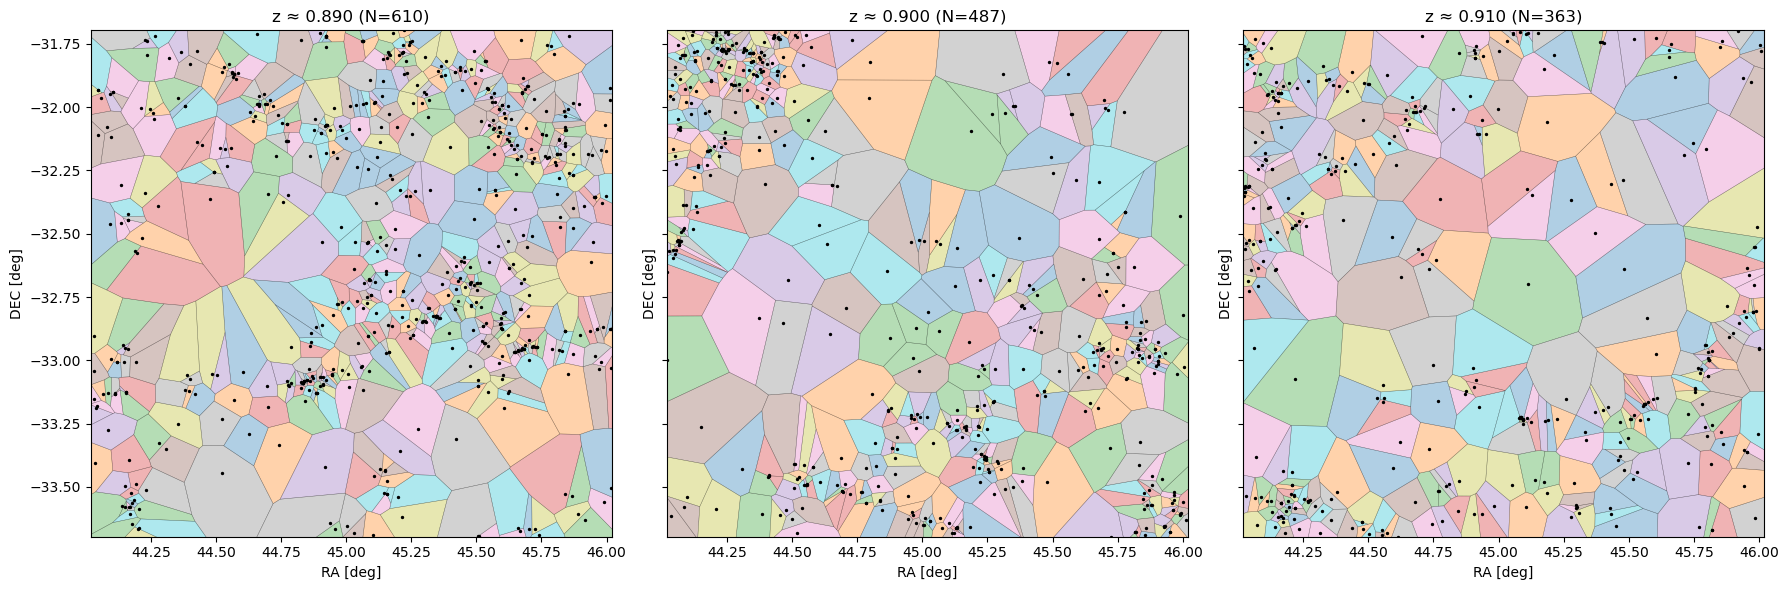

In [9]:
# Parameters for redshift slicing
n_slices = 3                # number of redshift shells to visualize
dz = 0.002                  # half-thickness of each shell in redshift units
min_points_per_shell = 10   # skip shells with too few points

rzmin, rzmax = float(redshift_selected.min()), float(redshift_selected.max())
z_centers = [rzmin + (rzmax - rzmin) * f for f in (0.25, 0.5, 0.75)]
print(f"Redshift range in selection: [{rzmin:.5f}, {rzmax:.5f}]; shell half-thickness dz={dz}")

# Plot Voronoi tessellations in RA-DEC for thin redshift shells
fig, axes = plt.subplots(1, n_slices, figsize=(18, 6), sharex=True, sharey=True)
if n_slices == 1:
    axes = [axes]

for z0, ax in zip(z_centers, axes):
    shell_mask = (redshift_selected >= z0 - dz) & (redshift_selected <= z0 + dz)
    pts = np.vstack([ra_selected[shell_mask], dec_selected[shell_mask]]).T
    ax.set_title(f"z ≈ {z0:.3f} (N={len(pts)})")
    ax.set_xlabel("RA [deg]")
    ax.set_ylabel("DEC [deg]")

    if pts.shape[0] < min_points_per_shell:
        ax.text(0.5, 0.5, "Too few points in shell", transform=ax.transAxes, ha='center', va='center')
        continue

    try:
        vor2d = Voronoi(pts)
        # Convert infinite regions to finite polygons (clipped)
        regions, vertices = voronoi_finite_polygons_2d(vor2d)
        for region in regions:
            polygon = vertices[region]
            ax.fill(polygon[:, 0], polygon[:, 1], alpha=0.35, edgecolor='k', linewidth=0.3)
        ax.scatter(pts[:, 0], pts[:, 1], s=2, c='k', zorder=3)
    except Exception as e:
        ax.scatter(pts[:, 0], pts[:, 1], s=2, c='k')
        ax.text(0.02, 0.98, f"Voronoi failed: {e}", transform=ax.transAxes, va='top')

    ax.set_xlim(float(ra_selected.min()), float(ra_selected.max()))
    ax.set_ylim(float(dec_selected.min()), float(dec_selected.max()))

plt.tight_layout()
plt.show()


# Plotly 3D plot of the galaxies

In [15]:
import plotly.graph_objects as go


# plot the galaxies in 3D
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color='blue',
        opacity=0.8
    )
))

fig.show()

In [11]:
# # Plot Voronoi tessellations in X-Y for thin redshift shells (slicing by redshift)
# fig, axes = plt.subplots(1, n_slices, figsize=(18, 6), sharex=True, sharey=True)
# if n_slices == 1:
#     axes = [axes]

# for z0, ax in zip(z_centers, axes):
#     shell_mask = (redshift_selected >= z0 - dz) & (redshift_selected <= z0 + dz)
#     pts = np.vstack([x[shell_mask], y[shell_mask]]).T
#     ax.set_title(f"z ≈ {z0:.3f} (N={len(pts)})")
#     ax.set_xlabel("X")
#     ax.set_ylabel("Y")

#     if pts.shape[0] < min_points_per_shell:
#         ax.text(0.5, 0.5, "Too few points in shell", transform=ax.transAxes, ha='center', va='center')
#         continue

#     try:
#         vor2d = Voronoi(pts)
#         regions, vertices = voronoi_finite_polygons_2d(vor2d)
#         for region in regions:
#             polygon = vertices[region]
#             ax.fill(polygon[:, 0], polygon[:, 1], alpha=0.35, edgecolor='k', linewidth=0.3)
#         ax.scatter(pts[:, 0], pts[:, 1], s=2, c='k', zorder=3)
#     except Exception as e:
#         ax.scatter(pts[:, 0], pts[:, 1], s=2, c='k')
#         ax.text(0.02, 0.98, f"Voronoi failed: {e}", transform=ax.transAxes, va='top')

#     ax.set_xlim(float(x_min), float(x_max))
#     ax.set_ylim(float(y_min), float(y_max))
#     ax.set_aspect('equal', adjustable='box')

# plt.tight_layout()
# plt.show()


# Save Voronoi cells to input into Machine Learning model

In [12]:
# Save Voronoi minimal features for ML (coords, volumes, adjacency)
if vor3d is None:
    raise RuntimeError("3D Voronoi not available; run the tessellation cell above first.")

features = build_voronoi_graph_and_volumes(
    vor3d,
    clip_bbox=(x_min, x_max, y_min, y_max, z_min, z_max),   # treat cells crossing bbox as unbounded
)

save_path = galaxy_info_dir / "galaxy_subset_voronoi.npz"
save_features_npz(features, save_path)
print(f"Saved minimal Voronoi features to {save_path}")

Saved minimal Voronoi features to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data/galaxy_info_files/galaxy_subset_voronoi.npz


In [13]:
# Build adjacency edge_index (2, E) from CSR and quick summary
edge_index = build_edge_index_from_csr(features["indptr"], features["indices"])
print(f"Edge index shape: {edge_index.shape}")
print(f"Finite cells: {int(np.sum(features['finite_mask']))} / {features['points'].shape[0]}")

Edge index shape: (2, 84758)
Finite cells: 5031 / 5711


# Load later

In [16]:
# Load previously saved minimal Voronoi features for ML
path = galaxy_info_dir / "galaxy_subset_voronoi.npz"
with np.load(path, allow_pickle=True) as saved:
    coords = saved["points"]            # (N, 3) site coordinates
    volumes = saved["volumes"]          # (N,) cell volumes (nan for unbounded/clipped)
    indptr = saved["indptr"]            # CSR pointers
    indices = saved["indices"]          # CSR indices (neighbors)
    finite_mask = saved["finite_mask"]   # (N,) boolean mask

# Build edge_index (2, E) for graph ML
edge_index = build_edge_index_from_csr(indptr, indices)

print(f"coords: {coords.shape} | volumes: {volumes.shape} | edge_index: {edge_index.shape}")
print(f"finite cells: {int(finite_mask.sum())} / {coords.shape[0]}")

# Optional: convert to PyTorch tensors for ML dataloaders
try:
    import torch
    x = torch.from_numpy(coords).float()            # node features (here: coordinates)
    vol = torch.from_numpy(volumes).float()         # per-node volume (may contain NaN for unbounded)
    edge_index_t = torch.from_numpy(edge_index).long()
    finite_mask_t = torch.from_numpy(finite_mask)
    print("Torch tensors -> x:", x.shape, "vol:", vol.shape, "edge_index:", edge_index_t.shape)
except Exception as e:
    print("Torch not available or failed to import:", e)

coords: (5711, 3) | volumes: (5711,) | edge_index: (2, 84758)
finite cells: 5031 / 5711
Torch tensors -> x: torch.Size([5711, 3]) vol: torch.Size([5711]) edge_index: torch.Size([2, 84758])
